In [1]:
import math
import importlib

import pickle
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from ax import Client, RangeParameterConfig

from botorch.models import SingleTaskGP
from botorch.acquisition import qLogExpectedImprovement, qMaxValueEntropy

from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.priors import GammaPrior

from src.ax_helper import get_full_strategy
from src import GPVisualiser, ax_helper
from src.ax_helper import get_guess_coords
import logging
from src.ax_helper import silence_ax_client, get_full_strategy
from src.toy_functions import Hartmann6D
import pickle

silence_ax_client()


-0.0 -0.9874311636230129


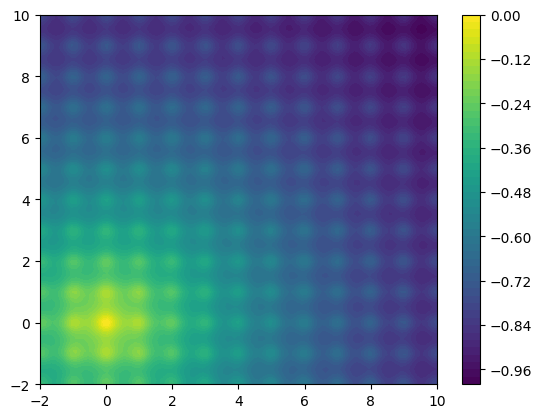

In [2]:
range_parameters = [
    RangeParameterConfig(
        name="x1", parameter_type="float", bounds=(-2, 10)
    ),
    RangeParameterConfig(
        name="x2", parameter_type="float", bounds=(-2, 10)
    )
]

metric_name = "response"
dim_names = ["x1", "x2"]


def test_function(x1, x2):
    # Ackley function (commonly used for optimization benchmarks)
    a = 20
    b = 0.2
    c = 2 * math.pi
    sum_sq = 0.5 * (x1**2 + x2**2)
    cos_comp = 0.5 * (math.cos(c * x1) + math.cos(c * x2))
    ackley_grid = -a * math.exp(-b * math.sqrt(sum_sq)) - math.exp(cos_comp) + a + math.exp(1)
    standardized = (ackley_grid-0.2434339681166695)/(19.3680592868830)
    return -standardized


import numpy as np
grid = np.linspace(-2, 10, 101)
x1_grid, x2_grid = np.meshgrid(grid, grid)
ackley_vals = np.array([test_function(x1, x2) for x1, x2 in zip(x1_grid.ravel(), x2_grid.ravel())]).reshape(x1_grid.shape)
ackley_vals
print(ackley_vals.max(), ackley_vals.min())


plt.contourf(x1_grid, x2_grid, ackley_vals, levels=60, cmap="viridis")
plt.colorbar()

# Sobol
The default initial parameter exploration strategy uses SOBOL algorithm:

### log param sobol:

In [3]:
import logging
import builtins

class SuppressInfoPrefix(logging.Filter):
    def filter(self, record):
        return not record.getMessage().startswith('[INFO')

# Create and register the filter globally (all loggers)
_filter = SuppressInfoPrefix()
root_logger = logging.getLogger()
root_logger.addFilter(_filter)
for handler in root_logger.handlers:
    handler.addFilter(_filter)

# Also add to any already-created loggers
for logger_name, lg in logging.root.manager.loggerDict.items():
    if isinstance(lg, logging.Logger):
        lg.addFilter(_filter)
        for h in lg.handlers:
            h.addFilter(_filter)

# Optional: suppress bare print() lines starting with '[INFO'
_original_print = builtins.print
def filtered_print(*args, **kwargs):
    if args and isinstance(args[0], str) and args[0].startswith('[INFO'):
        return
    _original_print(*args, **kwargs)

builtins.print = filtered_print


   trial_name         x0         x1
0         0_0  10.000000  10.000000
1         1_0  36.867765  34.340211
2         2_0   1.308201   1.690832
3         3_0   4.692024  14.357982
4         4_0  14.209723   4.048827
5         5_0  23.003828  28.429682
6         6_0   6.511970   6.010103
7         7_0   2.509858  68.057248
8         8_0  82.506450   2.513609
9         9_0  58.939683  11.895970
10       10_0   1.944063   4.217528
11       11_0   9.991909  49.720675
12       12_0  28.189992   1.010132
13       13_0  10.809831  85.284126
14       14_0   3.292174   2.308549
15       15_0   1.574606  20.408858
16       16_0  55.559097   9.657103
17       17_0  45.717884  23.286179
18       18_0   1.384462   8.559384
19       19_0   3.723632  97.252301
20       20_0  13.213710   2.047306
21       21_0  24.897361  42.541880
22       22_0   8.185072   1.193915
23       23_0   2.365697  10.172587
24       24_0  66.963933   4.987715
25       25_0  97.166286  60.220077
26       26_0   2.741142   2

<Axes: xlabel='x0', ylabel='x1'>

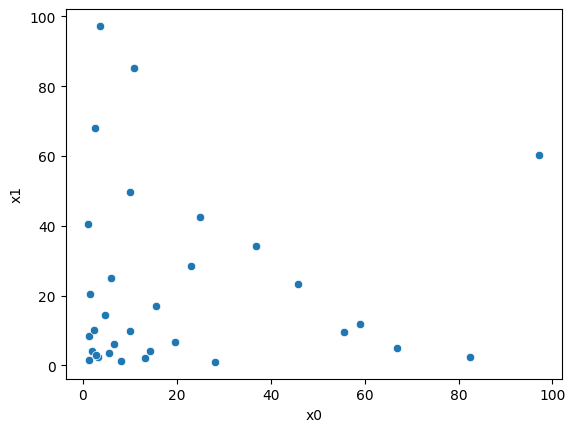

In [ ]:

client = Client()


client.configure_experiment(
    name="batch_bo_test",
    parameters=[
        RangeParameterConfig(
            name=f"x{i}",
            bounds=(1, 100),
            parameter_type="float",
            scaling = 'log',
        ) for i in range(len(dim_names))
    ],
)

client.configure_optimization(objective="-loss")
client.get_next_trials(max_trials=32)
coords = get_guess_coords(client)
print(coords)
sns.scatterplot(data=coords, x="x0", y="x1")

Low value oversampling is inline with logarithmic distribution.

**Considering that we expect overexpression to be optimal when compared to underexpression, Sobol should be run on a linear scale**.

### linear parameters sobol

<Axes: xlabel='x1', ylabel='x2'>

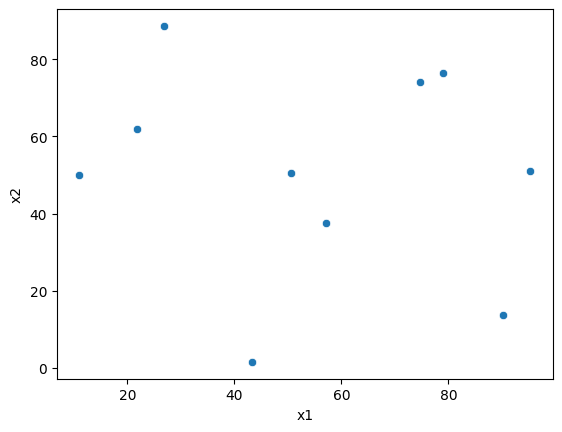

In [5]:
client = Client()

parameters=[
    RangeParameterConfig(
        name=dim,
        bounds=(1, 100),
        parameter_type="float",
        # scaling = 'log',
    ) for dim in dim_names
]


client.configure_experiment(
    name="batch_bo_test",
    parameters=parameters
)

client.configure_optimization(objective="response")
client.get_next_trials(max_trials=10)

coords = get_guess_coords(client)

sns.scatterplot(data=coords, x="x1", y="x2")

A nice and informative initial guess grid is formed

c:\Users\326po\AppData\Local\pypoetry\Cache\virtualenvs\bo-coli-wM2eEb6D-py3.13\Lib\site-packages\botorch\models\utils\assorted.py:270: InputDataWarning:

Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.



(<Figure size 1200x600 with 2 Axes>,
 array([<Axes: title={'center': 'GP along x1'}, xlabel='x1', ylabel='response'>,
        <Axes: title={'center': 'GP along x2'}, xlabel='x2', ylabel='response'>],
       dtype=object))

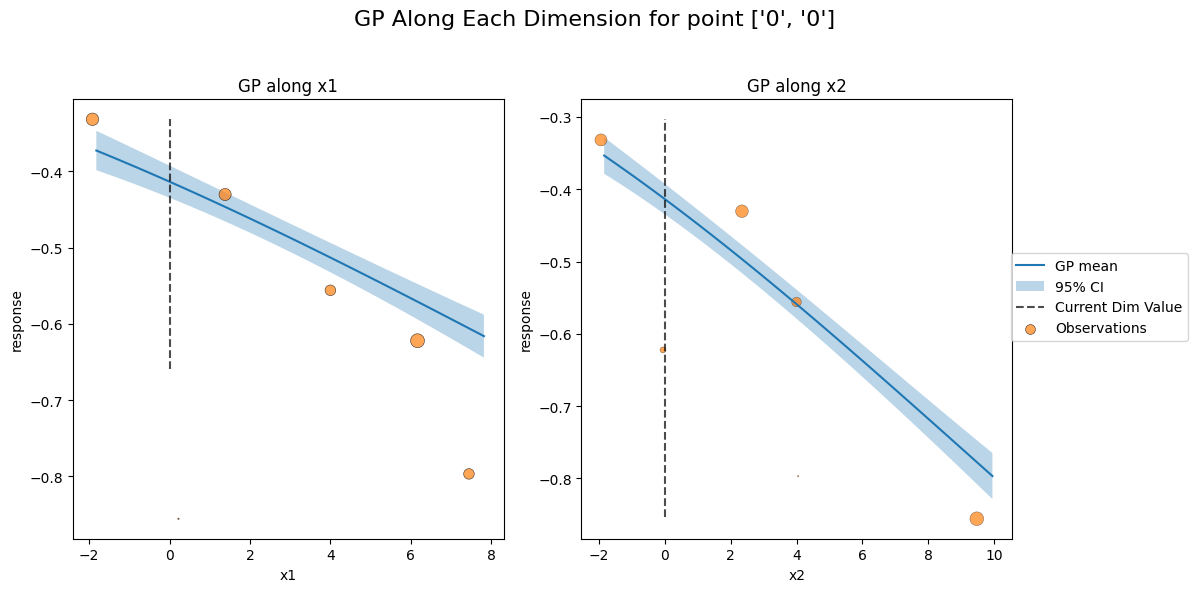

In [6]:
client = Client()

client.configure_experiment(parameters=range_parameters)


client.configure_optimization(objective=metric_name)

from src import ax_helper
importlib.reload(ax_helper)

batch_handler = ax_helper.BatchClientHandler(client, test_function, dim_names, metric_name, batch_size=6, range_params=range_parameters)
batch_handler.get_next_batch()
batch_handler.complete_all_pending()

df = ax_helper.get_obs_from_client(client, response_col='response')
plotter = GPVisualiser.GPVisualiserMatplotlib(SingleTaskGP, df, dim_names, 'response', parameters)
plotter.plot_all([0,0])

In [7]:
df

,trial_name,x1,x2,response
0,0_0,4.000000,4.000000,-0.556069
1,1_0,1.381989,2.342544,-0.430369
2,2_0,7.444812,4.048767,-0.796947
3,3_0,6.165687,-0.054917,-0.622236
4,4_0,0.222329,9.475768,-0.855796
5,5_0,-1.916352,-1.937686,-0.331724


# Custom Botorch model

### Define the GP surrogate


MES (max value entropy search) should be the ideal choice for acquisition functions because:
* It can handle noise.
* Samples in a manner to best define the optimum.
    * Consequently, will rarely repeat exactly identical samplings.
* Has a cost/fidelity setting

In [8]:
client = Client()
generation_strategy = get_full_strategy(gp=SingleTaskGP, acqf_class=qLogExpectedImprovement)
client.configure_experiment(parameters=range_parameters)

client.set_generation_strategy(
    generation_strategy=generation_strategy,
)
client.configure_optimization(objective=metric_name)

from src import ax_helper
importlib.reload(ax_helper)

batch_handler = ax_helper.BatchClientHandler(client, test_function, dim_names, metric_name, batch_size=1, range_params=range_parameters)
batch_handler.get_next_batch()
batch_handler.complete_all_pending()

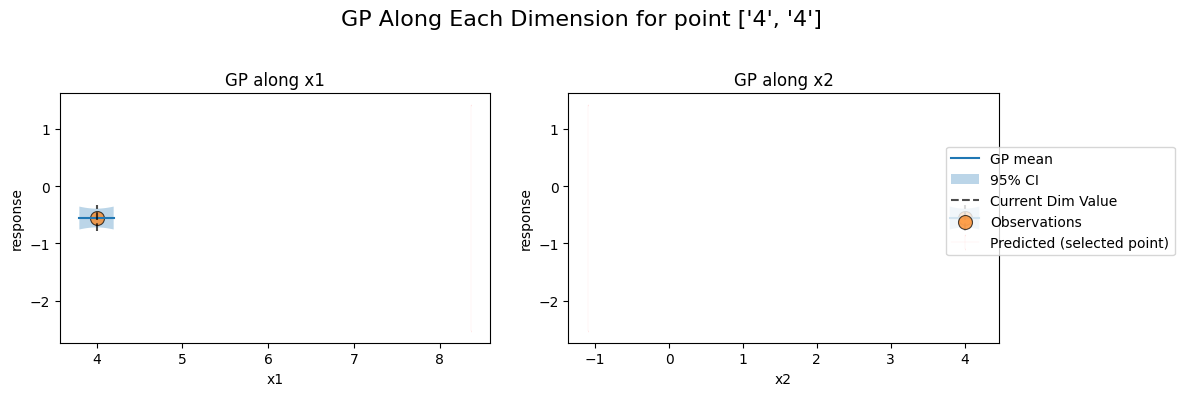

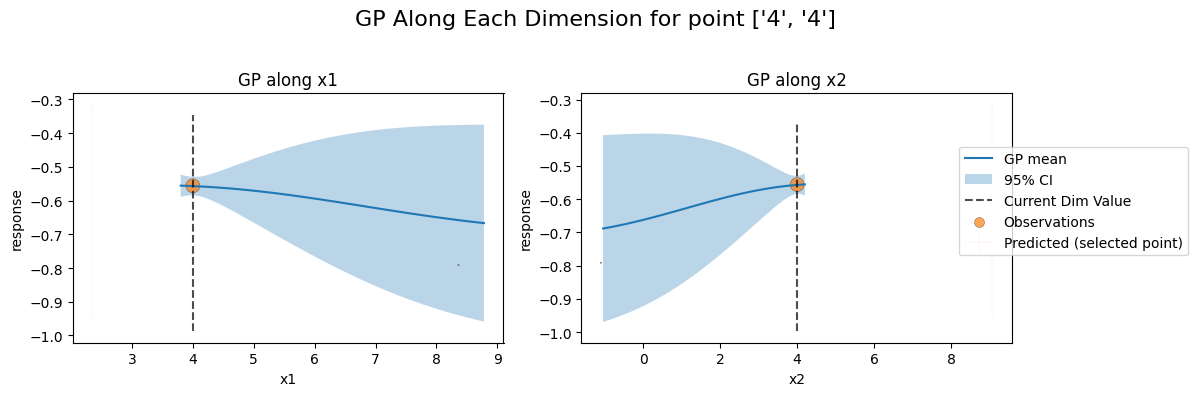

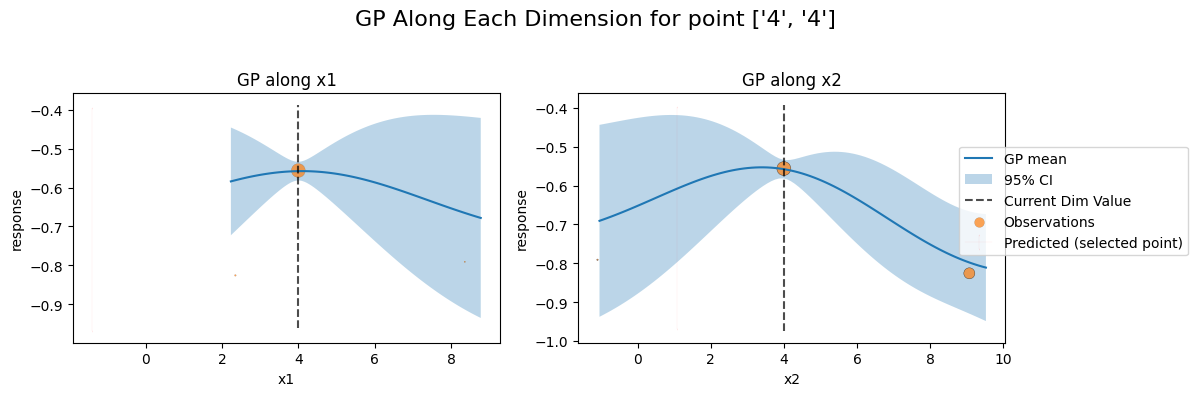

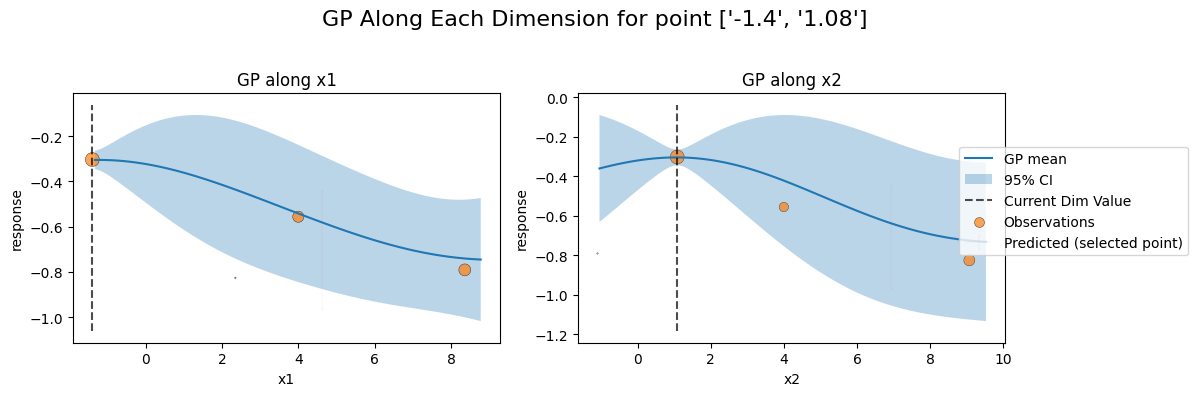

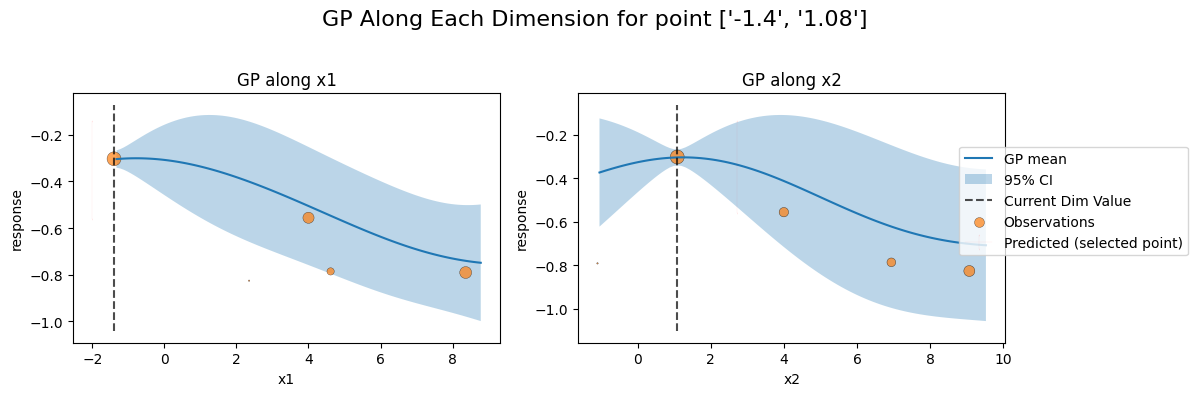

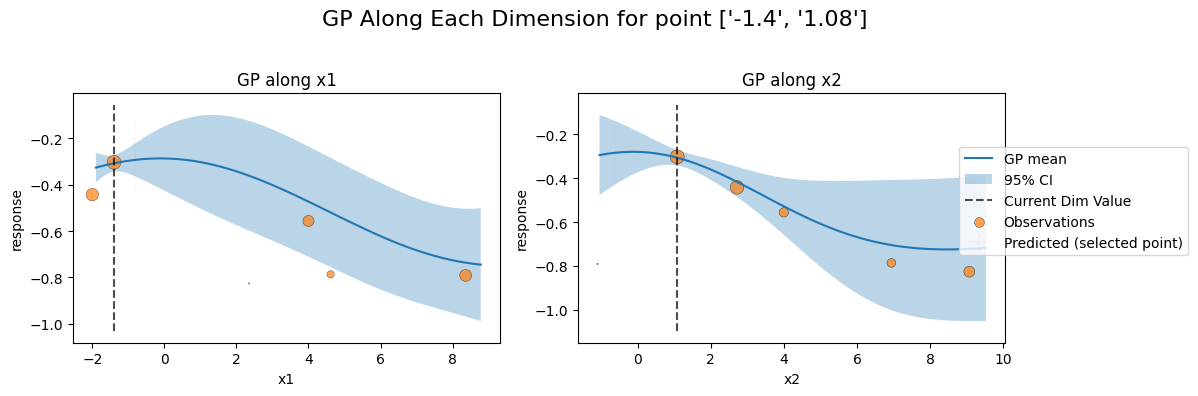

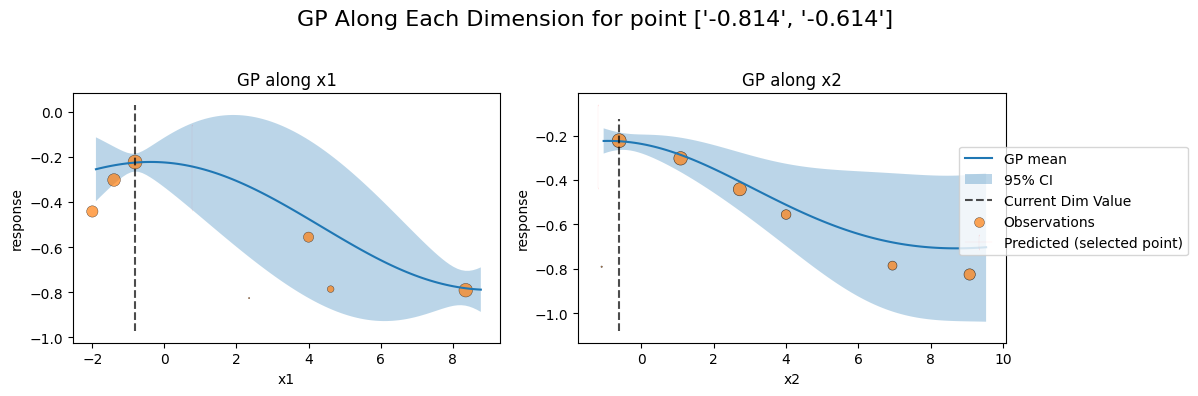

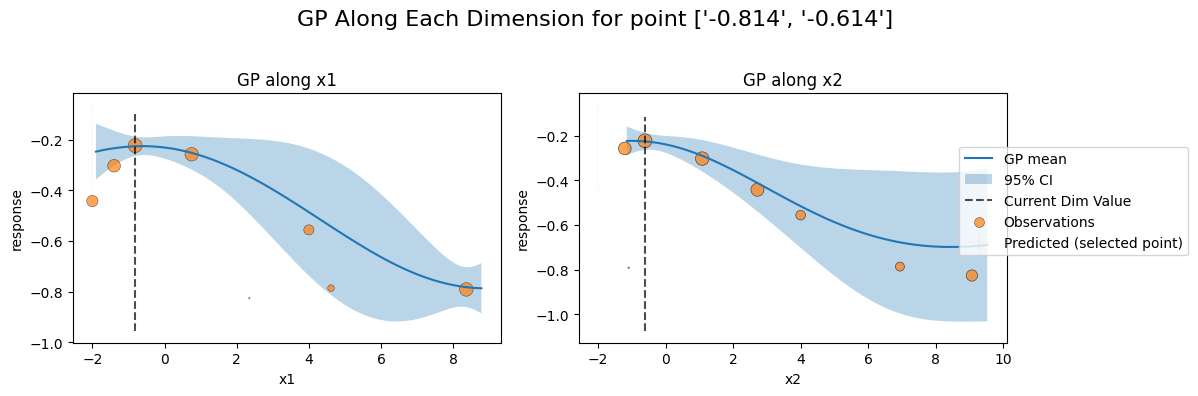

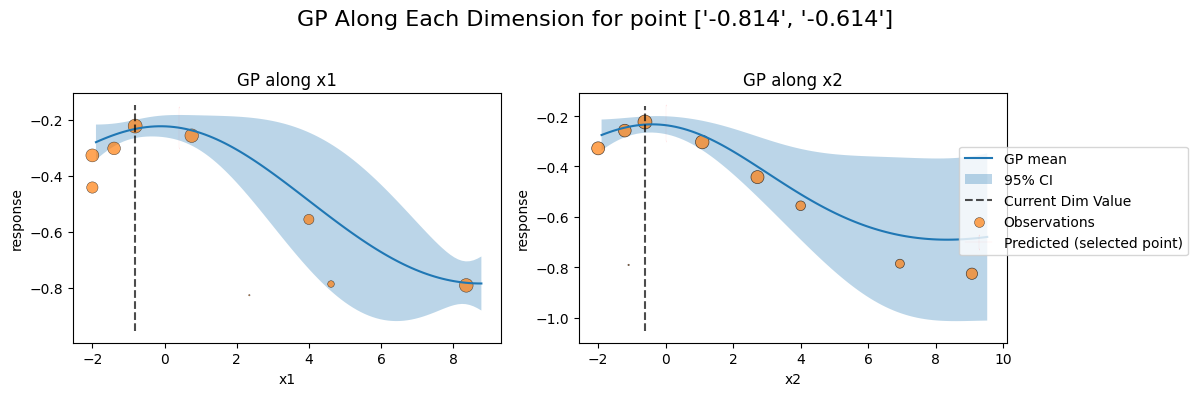

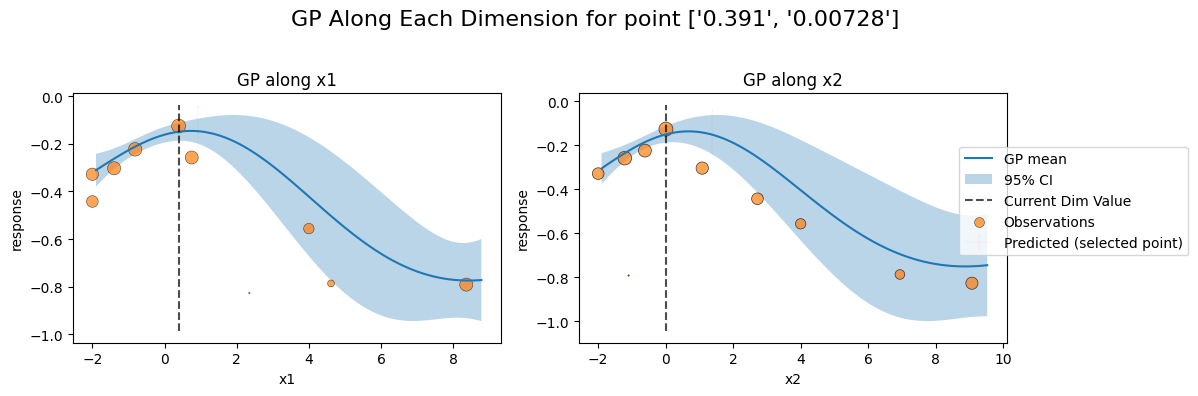

In [9]:
import matplotlib.pyplot as plt
for _ in range(10):
    batch_handler.get_next_batch()

    batch_handler.plot_GP(SingleTaskGP, figsize=(12, 4))
    batch_handler.complete_all_pending()


In [10]:
df

,trial_name,x1,x2,response
0,0_0,4.000000,4.000000,-0.556069
1,1_0,1.381989,2.342544,-0.430369
2,2_0,7.444812,4.048767,-0.796947
3,3_0,6.165687,-0.054917,-0.622236
4,4_0,0.222329,9.475768,-0.855796
5,5_0,-1.916352,-1.937686,-0.331724


# Technical repeats
Knowing that real biological data posses significant significant noise, the model has to be robust enough to handle technical repeats

In [11]:
range_parameters = [
    RangeParameterConfig(
        name="x1", parameter_type="float", bounds=(-2, 10)
    )
]

metric_name = "response"
dim_names = ["x1"]

def test_function(x1):
    # Original: y = -((x1 - 2) ** 2) + 10  -> range on [-2,10] is [-54, 10]
    y = -((x1 - 2) ** 2) + 10
    return (y + 54) / 64  # scale to [0,1]


noise_fn = lambda x, y: y + np.random.normal(0, 1)

def plot_test():
    plt.plot(np.linspace(-2, 10, 100), [test_function(x) for x in np.linspace(-2, 10, 100)], color='black', label='True function')

In [12]:
from src.ax_helper import SequentialRuns
SequentialRuns

src.ax_helper.SequentialRuns

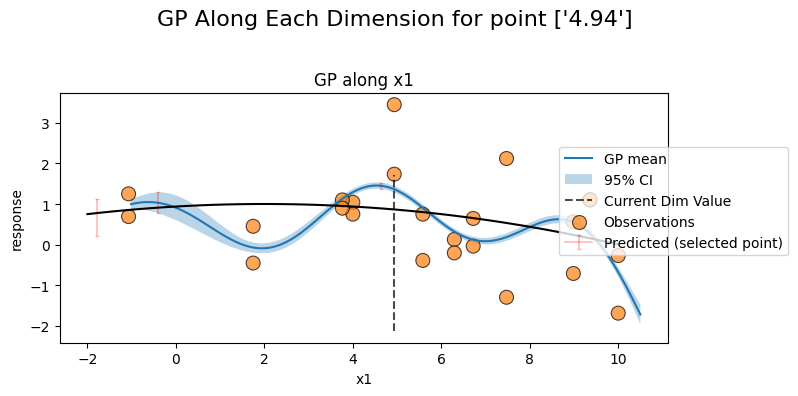

In [13]:
tester = SequentialRuns(test_function, range_parameters, dim_names, metric_name)

runs = tester.run(
    SingleTaskGP,
    n_runs=4,
    technical_repeats=2,
    batch_size=3,
    noise_fn=noise_fn,
    plot_each=False,
)
runs.plot_GP(SingleTaskGP, figsize=(8, 4))
plot_test()

* This simple Kernel is incapable of encompassing noise. Consequently, it overfits.
* Technical repeats slightly improve the situation, however they do not fix the problem.

### GP + noise

Simply adding a lot of noise, significantly improves the fit.
 

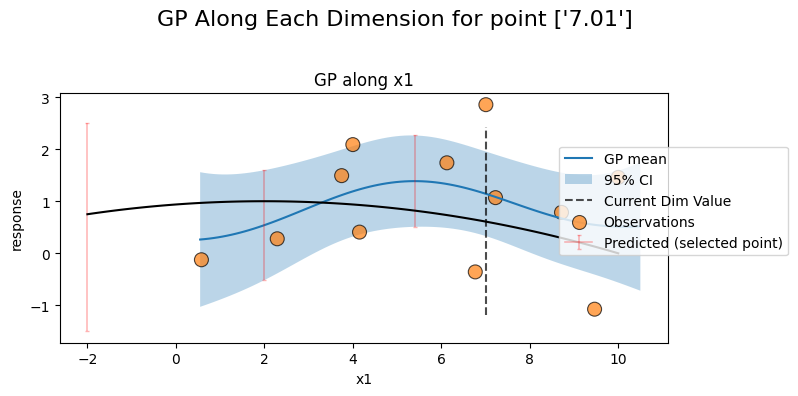

In [14]:
from src.model_generation import GammaNoiseSGP


runs = tester.run(
    GammaNoiseSGP,
    n_runs=4,
    technical_repeats=1,
    batch_size=3,
    noise_fn=noise_fn,
    plot_each=False,
).plot_GP(GammaNoiseSGP, figsize=(8, 4))


plot_test()

* Introducing a noise channel significantly improves fit performance, even if no technical repeats are provided to narrow down the mean.
However,a heteroscedastic, or at least technical repeat aware noise kernel would be preferable.

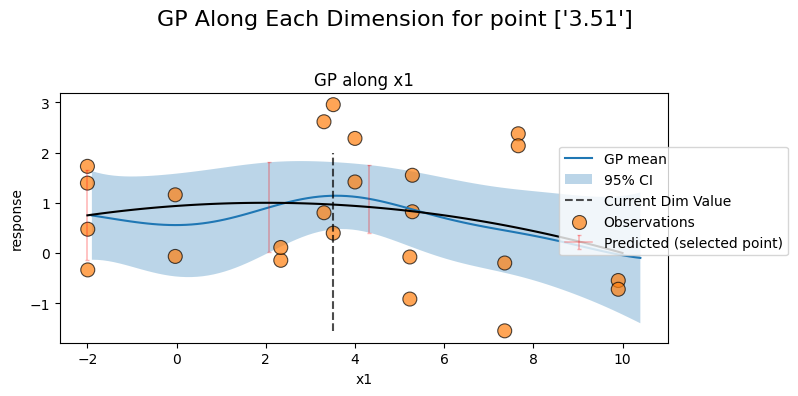

In [15]:
runs = tester.run(GammaNoiseSGP, n_runs=4, technical_repeats=2, batch_size=3, noise_fn=noise_fn, plot_each=False).plot_GP(GammaNoiseSGP, figsize=(8, 4))
plot_test()

It appears that technical repeats significantly improve noise resolution for the kernel, however, more quantitative tests are required.

# Heteroscedastic noise

c:\Users\326po\AppData\Local\pypoetry\Cache\virtualenvs\bo-coli-wM2eEb6D-py3.13\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning:

A not p.d., added jitter of 1.0e-08 to the diagonal



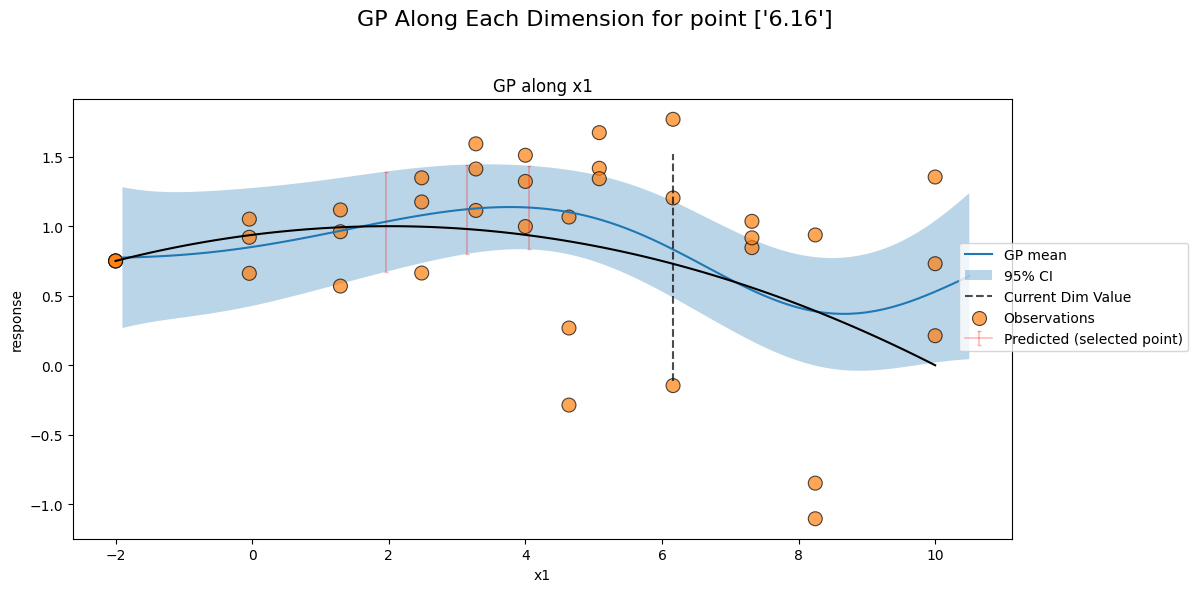

In [16]:
def noise_fn_low(x, y= None):
    return y + np.random.normal(0, 1)*(x['x1']+2)/12


runs = tester.run(GammaNoiseSGP, n_runs=4, technical_repeats=3, batch_size=3, noise_fn=noise_fn_low, plot_each=False)
runs.plot_GP(GammaNoiseSGP, figsize=(12, 6))
plot_test()

* The white noise kernel is unable to accommodate linear heteroscedastic noise.

## Technical repeat adaptive kernel

c:\Users\326po\AppData\Local\pypoetry\Cache\virtualenvs\bo-coli-wM2eEb6D-py3.13\Lib\site-packages\gpytorch\likelihoods\noise_models.py:150: NumericalWarning:

Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.



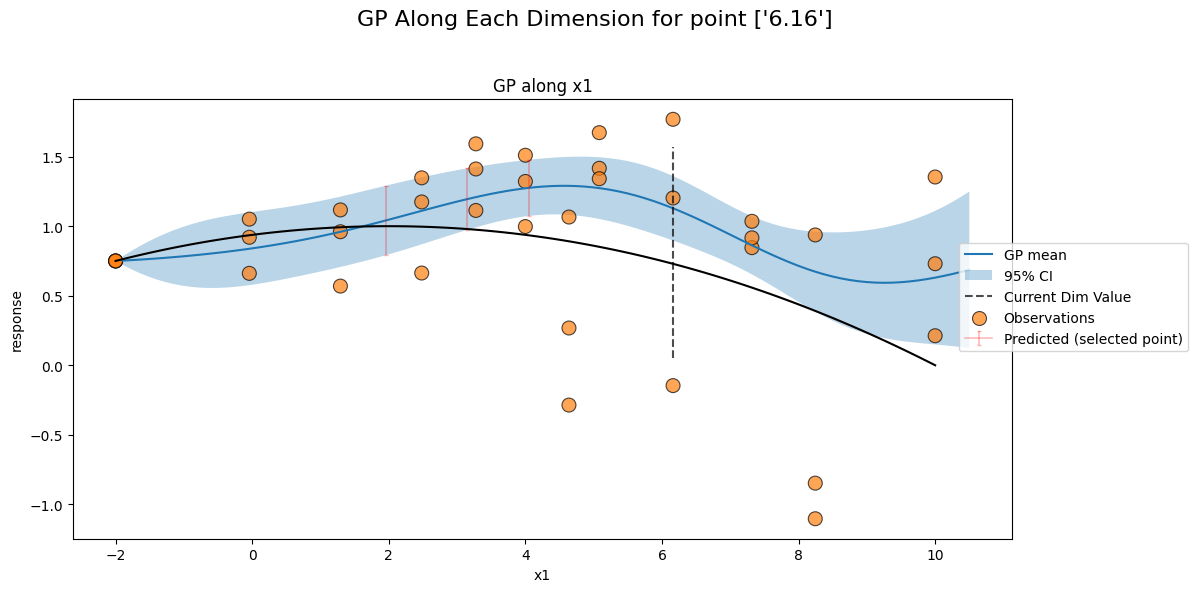

In [17]:
from src.model_generation import HeteroNoiseSGP, HeteroWhiteSGP
        

runs.plot_GP(HeteroNoiseSGP, figsize=(12, 6))
plot_test()




* Fitting a gp to pre-investigated data appear perform quite badly 

## Heteroscedastic + fixed white noise

tensor([0.3120, 0.2511, 0.2263, 0.3120, 0.3120, 0.2511, 0.2511, 0.2263, 0.2263,
        1.1642, 0.6241, 0.1483, 1.1642, 1.1642, 0.6241, 0.6241, 0.1483, 0.1483,
        1.0363, 0.4085, 0.1053, 1.0363, 1.0363, 0.4085, 0.4085, 0.1053, 0.1053,
        0.3347, 0.7323, 0.2945, 0.3347, 0.3347, 0.7323, 0.7323, 0.2945, 0.2945],
       dtype=torch.float64, grad_fn=<AddBackward0>)


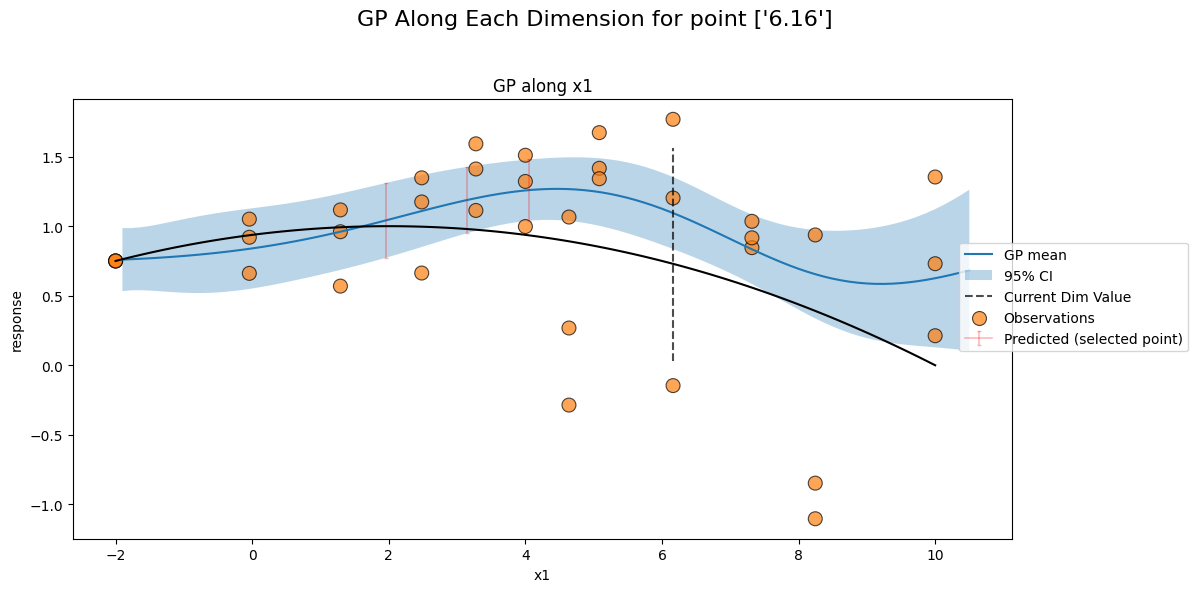

In [18]:


runs.plot_GP(HeteroWhiteSGP, figsize=(12, 6))
plot_test()

Much better performance when data is acquired during the run.

# Quantification of Noise, technical repeats, and batch size.

6 dimensional hartman function is used for evaluation, due to its high dimensionality, multiple local optima, ridges and non-linear interactions.

In [19]:


save_dir = "data/bayes_sim/"
h6 = Hartmann6D().eval_at

_h6_x_opt = torch.tensor([0.20169, 0.150011, 0.476874, 0.275332, 0.311652, 0.6573])
h_6_max = [float(h6(*_h6_x_opt)) for _ in range(10000)]
h_6_max

[3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,
 3.416637659072876,


In [20]:
hartmann6_range_parameters = [
    RangeParameterConfig(name=f"x{i+1}", parameter_type="float", bounds=(0.0, 1.0))
    for i in range(6)
]
dim_names_h6 = [rp.name for rp in hartmann6_range_parameters]

tester = SequentialRuns(h6, hartmann6_range_parameters, dim_names_h6, metric_name)
tester

## Sequential runs no noise

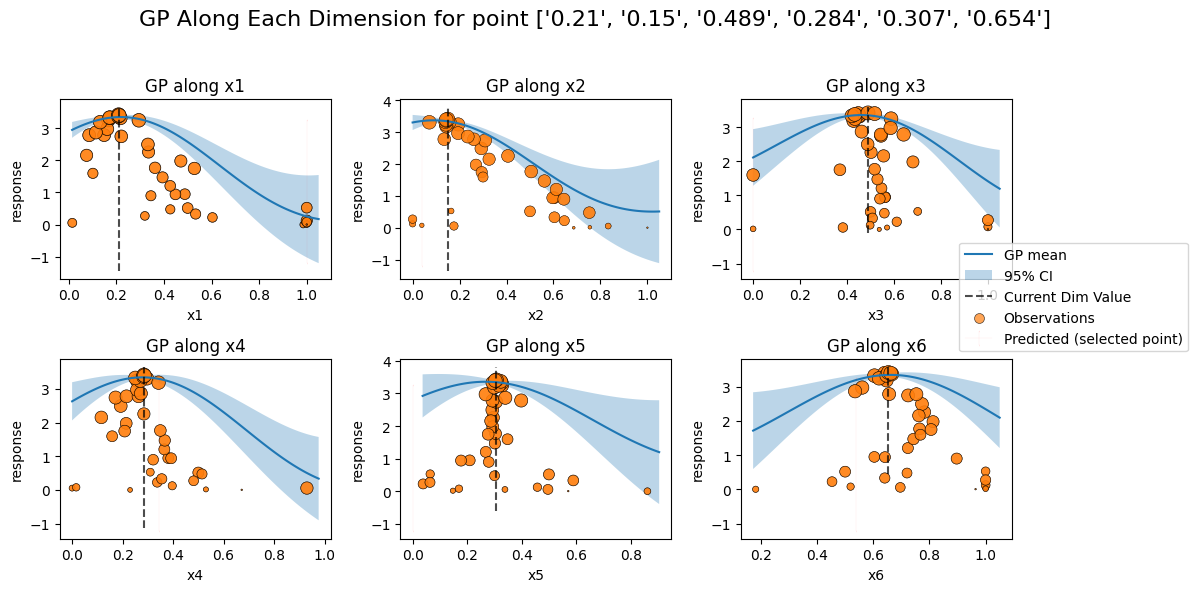

In [24]:
def noise_fn(x, y):
    return y

save_dir = "data/bayes_sim/"
runs = tester.run(SingleTaskGP, n_runs=40, technical_repeats=2, batch_size=1, noise_fn=noise_fn, plot_each=False)
runs.plot_GP(SingleTaskGP)

* Save the data for our testing purposes

In [30]:
client_dir = r"data/ax_clients/"
runs.client.save_to_json_file(client_dir + "hartmann6_runs.json")

In [37]:
client._experiment.parameters.keys()

dict_keys(['x1', 'x2', 'x3', 'x4', 'x5', 'x6'])

In [39]:
dir(client._experiment)

['__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__firstlineno__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__static_attributes__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_arms_by_name',
 '_arms_by_signature',
 '_attach_trial',
 '_cache_metric_fetch_error',
 '_check_TTL_on_running_trials',
 '_data_by_trial',
 '_db_id',
 '_default_data_type',
 '_eq_skip_db_id_check',
 '_experiment_type',
 '_fetch_trial_data',
 '_get_last_data_without_similar_rows',
 '_initial_auxiliary_experiments_by_purpose',
 '_is_test',
 '_lookup_or_fetch_trials_results',
 '_metric_fetching_errors',
 '_metrics_by_class',
 '_name',
 '_name_and_store_arm_if_not_exists',
 '_optimization_config',
 '_properties',
 '_register_arm',
 '_search_sp

In [41]:
client._experiment.metrics

{'response': MapMetric('response')}

In [32]:
client = Client().load_from_json_file(client_dir + "hartmann6_runs.json")
ax_helper.get_obs_from_client(client, response_col='response')

,trial_name,x1,x2,x3,x4,x5,x6,response
0,0_0,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.516406
1,0_0,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.516406
2,2_0,0.015262,0.175989,0.382362,0.930075,0.496385,0.696372,0.056858
3,2_0,0.015262,0.175989,0.382362,0.930075,0.496385,0.696372,0.056858
4,4_0,0.984956,0.686159,0.537164,0.229632,0.861281,0.181661,0.001834
...,...,...,...,...,...,...,...,...
76,76_0,0.320070,0.000000,1.000000,0.481355,0.063711,1.000000,0.272466
77,76_0,0.320070,0.000000,1.000000,0.481355,0.063711,1.000000,0.272466
78,78_0,1.000000,1.000000,1.000000,0.671791,0.570884,0.964199,0.004469
79,78_0,1.000000,1.000000,1.000000,0.671791,0.570884,0.964199,0.004469


## Noise vs technical repeats for sequential Single task GP
* SingleTaskGP
* qLogExpectedImprovement
* 100 sequential runs
* range [0, 3.4]
* Noise [0,2]
* Technical repeats: [1,8]

In [ ]:
break

In [ ]:
import src.stats_eval_helper as seh

In [ ]:
explo_dict:dict = pickle.load(open(save_dir + r"singleGP_noise_vs_t_repeats.pkl", "rb"))

def get_top_deciles(explo_dict):
    return {id:ax_helper.get_above_percentile(df, 3.4, .9) for id, df in explo_dict.items()}

get_top_deciles(explo_dict)
hits = seh.hit_stats(get_top_deciles(explo_dict))
hits

TP_index  \
tech_repeats noise                                                      
1            0.0    [34, 35, 36, 37, 38, 40, 41, 43, 44, 45, 47, 4...   
             0.2    [39, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 7...   
             0.4                                                   []   
             0.6                                                   []   
             0.8                                                   []   
...                                                               ...   
8            1.4                                                   []   
             1.6                                                   []   
             1.8                                                   []   
             2.0                                                   []   
             2.2                                                   []   

                        FP_index  \
tech_repeats noise                 
1            0.0              []   
             0.2        [52, 53]   
             0.4              []   
             0.6            [83]   
             0.8    [55, 92, 95]   
...                          ...   
8            1.4              []   
             1.6              []   
             1.8              []   
             2.0              []   
             2.2              []   

                                                             TN_index  \
tech_repeats noise                                                      
1            0.0    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
             0.2    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
             0.4    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
             0.6    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
             0.8    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
...                                                               ...   
8            1.4    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
             1.6    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
             1.8    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
             2.0    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
             2.2    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   

                                FN_index  TP FP   TN FN Precision    Recall  \
tech_repeats noise                                                            
1            0.0                      []  20  0   81  0       1.0       1.0   
             0.2    [40, 51, 61, 62, 80]  17  2   77  5  0.894737  0.772727   
             0.4                      []   0  0  101  0       0.0       0.0   
             0.6                      []   0  1  100  0       0.0       0.0   
             0.8                      []   0  3   98  0       0.0       0.0   
...                                  ...  .. ..  ... ..       ...       ...   
8            1.4                      []   0  0  101  0       0.0       0.0   
             1.6                      []   0  0   81  0       0.0       0.0   
             1.8                      []   0  0   40  0       0.0       0.0   
             2.0                      []   0  0   87  0       0.0       0.0   
             2.2                      []   0  0  101  0       0.0       0.0   

                   Specificity  Accuracy  
tech_repeats noise                        
1            0.0           1.0       1.0  
             0.2      0.974684  0.930693  
             0.4           1.0       1.0  
             0.6      0.990099  0.990099  
             0.8      0.970297  0.970297  
...                        ...       ...  
8            1.4           1.0       1.0  
             1.6           1.0       1.0  
             1.8           1.0       1.0  
             2.0           1.0       1.0  
             2.2           1.0       1.0  

[96 rows x 12 columns]

<Axes: xlabel='noise', ylabel='Accuracy'>

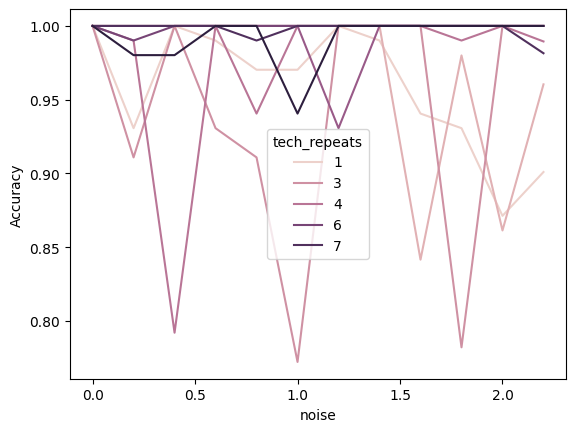

In [ ]:
sns.lineplot(data=hits, x="noise", hue="tech_repeats", y='Accuracy')

## Noise vs technical repeats for sequential Single task GP with Gamma noise
* Gamma noise
* qLogExpectedImprovement
* 100 sequential runs
* range [0, 3.4]
* Noise [0,2]
* Technical repeats: [1,8]

<Axes: xlabel='noise', ylabel='Accuracy'>

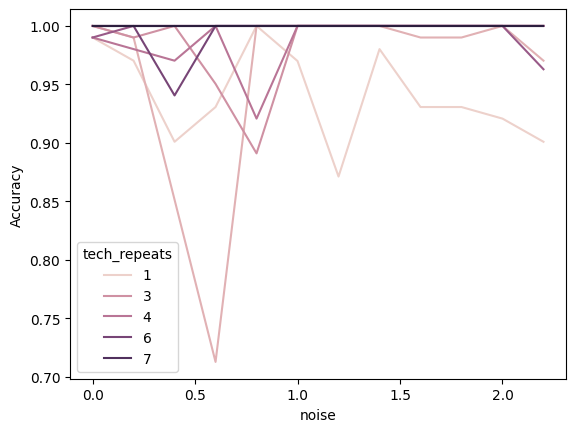

In [ ]:
explo_dict:dict = pickle.load(open(save_dir + r"GammaNoiseSGP_noise_vs_t_repeats.pkl", "rb"))
df = seh.hit_stats(get_top_deciles(explo_dict))
sns.lineplot(data=df, x="noise", hue="tech_repeats", y='Accuracy')